In [15]:
import torch
import os
from PIL import Image
import clip
import os.path as osp
import os, sys
import torchvision.utils as vutils
import string 
import pickle 
import numpy as np
import shutil
from numpy.random import shuffle
sys.path.insert(0, '../')

from lib.utils import load_model_weights,mkdir_p
from models.GALIP import NetG, CLIP_TXT_ENCODER

In [3]:
device = 'cpu' # 'cpu' # 'cuda:0'
CLIP_text = "ViT-B/32"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model = clip_model.eval()

In [4]:
text_encoder = CLIP_TXT_ENCODER(clip_model).to(device)
netG = NetG(64, 100, 512, 256, 3, False, clip_model).to(device)
#path = '../saved_models/pretrained/pre_cc12m.pth'
path = '../saved_models/fonts/GALIP_nf64_normal_fonts_256_2023_04_10_20_51_54/state_epoch_380.pth'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
netG = load_model_weights(netG, checkpoint['model']['netG'], multi_gpus=False)

## Experiment 1: Naturalness 
### Given 10 images of each character, how legible are the characters? 
####    Illegible; Somewhat Legible; Legible 


In [16]:
#Functions to implement that here 
e1_path = '../samples/e1'
mkdir_p(e1_path)

import string 

def generate_basic_caption_prompts():
    captions = []
    #lowercase
    for i in string.ascii_lowercase:
        x = 'A lowercase %s' % (i)
        captions.append(x)
    #uppercase
    for i in string.ascii_uppercase:
        x = 'An uppercase %s' % (i)
        captions.append(x)

    #digits
    for i in string.digits:
        x = 'The number %s' % (i)
        captions.append(x)

    return captions


# Go through test pickle file to see fonts we can test with 
# Try to find one instance for each a-z, A-Z, and 0-9

def get_captions_from_test_set():
    test_pickle_path = '../data/fonts/test/filenames.pickle'
    testing_file_names = pickle.load(open(test_pickle_path, 'rb'))

    char_list = []
    char_list.extend(string.ascii_letters)
    char_list.extend(string.digits)

    selected_file_paths = []
    #Retrieve one file name for each character
    for i in testing_file_names:
        shuffle(testing_file_names)
        char = i.split('\\')[0].split('_')[1]
        if char in char_list:
            char_list.remove(char)
            selected_file_paths.append(i)

    #For each selected path retrieve the corresponding caption 
    text_files_path = '../data//fonts//text'
    testing_captions = [] 

    for i in selected_file_paths:
        selected_file_text_path = os.path.join(text_files_path, i + '.txt')
        with open(selected_file_text_path) as f:
            caption_data = f.read()
            testing_captions.append(caption_data)

    return testing_captions
    


def experiment_1():
    batch_size = 10
    noise = torch.randn((batch_size, 100)).to(device)

    caps = generate_basic_caption_prompts()

    #Generate captions 

    # generate from text
    with torch.no_grad():
        for i in range(len(caps)):
            caption = caps[i]
            tokenized_text = clip.tokenize([caption]).to(device)
            sent_emb, word_emb = text_encoder(tokenized_text)
            sent_emb = sent_emb.repeat(batch_size,1)
            fake_imgs = netG(noise,sent_emb,eval=True).float()
            name = f'{caps[i].replace(" ", "-")}'
            vutils.save_image(fake_imgs.data, e1_path + '/%s.png'%(name), nrow=5, value_range=(-1, 1), normalize=True)

#experiment_1()

C:\Users\rinat\AppData\Local\Temp\ipykernel_18084\75036409.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


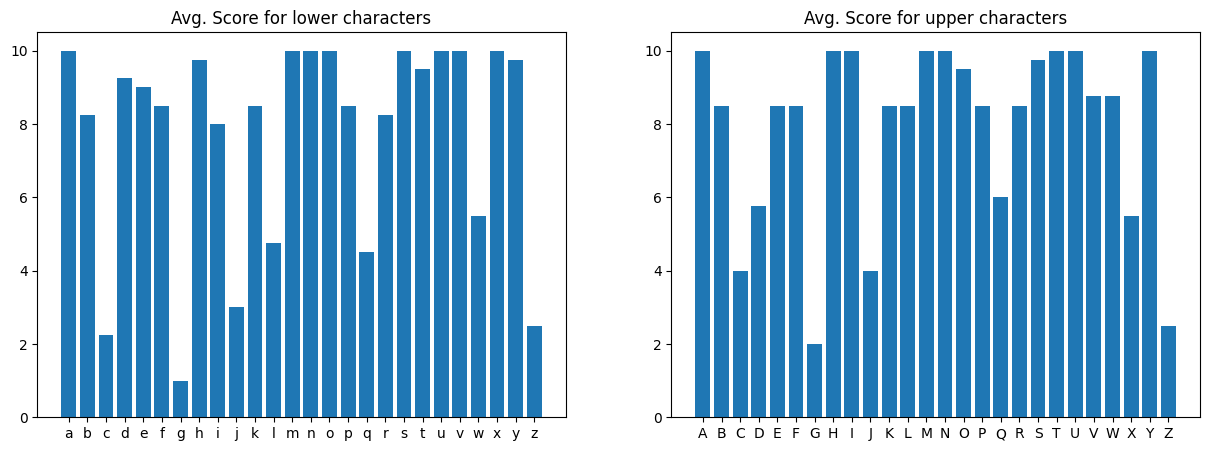

In [53]:
#Functions to process human evaluations into graphs here 
#sheet_url = 'https://docs.google.com/spreadsheets/d/1VB10WsgaWIzCrovDXRroJTSkjH0z4ARo0PgrkAkyOI8/'
import pandas as pd 
import matplotlib.pyplot as plt 
csv_path = 'AI Font Generation Evaluation (Responses) - Form Responses 1.csv'
df = pd.read_csv(csv_path)
required_cols = [2,53]
lower_char_legibility_map = {} #For each character, map legibility 
upper_char_legibility_map = {}

head = df.head()
num_legibility_scores = len(head.iloc[:, 2].values)

alphabet_ctr = 0
for i in range(required_cols[0], required_cols[1], 2):
    lower_label = string.ascii_lowercase[alphabet_ctr]
    upper_label = string.ascii_uppercase[alphabet_ctr]


    lower_label_legibility_score = head.iloc[:, i].values.sum()
    upper_label_legibility_score = head.iloc[:, i+1].values.sum()

    lower_label_legibility_score /= num_legibility_scores
    upper_label_legibility_score /= num_legibility_scores

    lower_char_legibility_map[lower_label] = lower_label_legibility_score
    upper_char_legibility_map[upper_label] = upper_label_legibility_score

    alphabet_ctr += 1 

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Avg. Score for lower characters')
plt.bar(range(len(lower_char_legibility_map)), list(lower_char_legibility_map.values()), tick_label=list(lower_char_legibility_map.keys()))

plt.subplot(1, 2, 2)
plt.title('Avg. Score for upper characters')
plt.bar(range(len(upper_char_legibility_map)), list(upper_char_legibility_map.values()), tick_label=list(upper_char_legibility_map.keys()))
plt.savefig('experiment1')

In [61]:
head.iloc[:, 54]

0    3
1    3
2    2
3    3
Name: How well do the generated characters follow the following prompt: \n\nLabel: lowercase a \nCharacteristics: Blocky\nFont Properties: Black weight, square corner rounding, sans serif, static, extended width, all-caps font , dtype: int64

## Experiment 2: Faithfulness
### Given 10 images of each character, how faithful are the characters to the prompt?
####    Not faithful; charachter only; character + some characteristics or properties; Faithful 


In [12]:
#Functions to implement here 
e2_path = '../samples/e2'
mkdir_p(e2_path)

#Note: the same thing as #1 if using captions from test set 
def experiment_2():
    batch_size = 10
    noise = torch.randn((batch_size, 100)).to(device)

    caps = get_captions_from_test_set()

    #Generate captions 

    # generate from text
    with torch.no_grad():
        for i in range(len(caps)):
            caption = caps[i]
            tokenized_text = clip.tokenize([caption]).to(device)
            sent_emb, word_emb = text_encoder(tokenized_text)
            sent_emb = sent_emb.repeat(batch_size,1)
            fake_imgs = netG(noise,sent_emb,eval=True).float()
            name = f'{caps[i].replace(" ", "-")}'
            vutils.save_image(fake_imgs.data, e2_path + '/%s.png'%(name), nrow=5, value_range=(-1, 1), normalize=True)

experiment_2()


C:\Users\rinat\AppData\Local\Temp\ipykernel_18084\2802293801.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


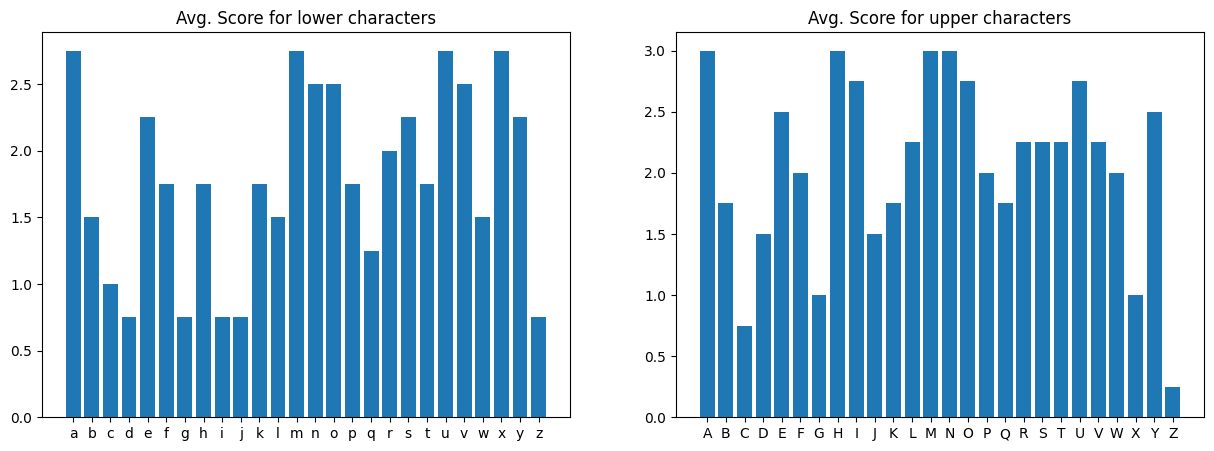

In [63]:
#Functions to process human eval here 

required_cols = [54,105]
lower_char_faithfulness_map = {} #For each character, map legibility 
upper_char_faithfulness_map = {}

num_faithfulness_scores = len(head.iloc[:, 54].values)

alphabet_ctr = 0
for i in range(required_cols[0], required_cols[1], 2):
    lower_label = string.ascii_lowercase[alphabet_ctr]
    upper_label = string.ascii_uppercase[alphabet_ctr]


    lower_label_faithfulness_score = head.iloc[:, i].values.sum()
    upper_label_faithfulness_score = head.iloc[:, i+1].values.sum()

    lower_label_faithfulness_score /= num_faithfulness_scores
    upper_label_faithfulness_score /= num_faithfulness_scores

    lower_char_faithfulness_map[lower_label] = lower_label_faithfulness_score
    upper_char_faithfulness_map[upper_label] = upper_label_faithfulness_score

    alphabet_ctr += 1 

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Avg. Score for lower characters')
plt.bar(range(len(lower_char_faithfulness_map)), list(lower_char_faithfulness_map.values()), tick_label=list(lower_char_faithfulness_map.keys()))

plt.subplot(1, 2, 2)
plt.title('Avg. Score for upper characters')
plt.bar(range(len(upper_char_faithfulness_map)), list(upper_char_faithfulness_map.values()), tick_label=list(upper_char_faithfulness_map.keys()))
plt.savefig('experiment2')

## Experiment 3: Machine generated characters vs Human designed characters
### Given 50 images (25 real, 25 machine generated) decide which one looks created by a designer and which one looks made by a machine
####    Machine-made; unsure; man-made  


In [11]:
#Functions to implement here
e3_path = '../samples/e3'
real = '../samples/e3/real'
fake = '../samples/e3/fake'
mkdir_p(e3_path)
mkdir_p(real)
mkdir_p(fake)

def get_real_images(image_path, img_count, save_path):
    #Loop through real image directory and get list of all images 
        #Randomly select 'img_count' images
        #Save those images to save_path

    ims = []
    for path, subdirs, files in os.walk(image_path):
        for name in files:
            ims.append(os.path.join(path, name))
    chosen_image_paths = np.random.choice(ims, img_count, replace=False)

    #Save images to save_path
    for i in chosen_image_paths:
        file_name = i.split('\\')[-1]
        destination_path = os.path.join(os.path.abspath(e3_path), file_name)
        shutil.copy(i, os.path.join(save_path, 'real', file_name))
    pass 

#Give me the path to the text data and a file name; I will return its contennts
def get_text_prompt(text_path, text_file_name):
    caption_data = ''
    selected_file_text_path = os.path.join(text_path, text_file_name + '.txt')
    with open(selected_file_text_path) as f:
        caption_data = f.read()
    return caption_data 

def get_fake_images(test_pickle_path, text_path, save_path, img_num):
    testing_file_names = pickle.load(open(test_pickle_path, 'rb'))

    char_list = []
    char_list.extend(string.ascii_letters)
    char_list.extend(string.digits)

    selected_file_paths = []
    #Retrieve one file name for each character
    for i in testing_file_names:
        char = i.split('\\')[0].split('_')[1]
        if char in char_list:
            char_list.remove(char)
            selected_file_paths.append(i)

    #For each selected path retrieve the corresponding caption
    #   Then use that caption to generate a singular image 
    #   Lastly, save that image to save_path 
    #  
    
    captions = []
    chosen_paths = np.random.choice(selected_file_paths, img_num, replace=False)
    for i in chosen_paths:
        caption = get_text_prompt(text_path, i)
        captions.append(caption)
        # generate from text
    
    batch_size = 1
    noise = torch.randn((batch_size, 100)).to(device)

    with torch.no_grad():
        for i in range(len(captions)):
            caption = captions[i]
            tokenized_text = clip.tokenize([caption]).to(device)
            sent_emb, word_emb = text_encoder(tokenized_text)
            sent_emb = sent_emb.repeat(batch_size,1)
            fake_imgs = netG(noise,sent_emb,eval=True).float()
            name = f'{captions[i].replace(" ", "-")}'
            vutils.save_image(fake_imgs.data, os.path.join(save_path, 'fake/') + '/%s.png'%(name), nrow=5, value_range=(-1, 1), normalize=True)

         
 

def get_images():
    image_path = '../data/fonts/images'
    test_pickle_path = '../data/fonts/test/filenames.pickle'
    save_path = e3_path
    text_path = '../data/fonts/text'
    get_real_images(image_path, 25, save_path)
    get_fake_images(test_pickle_path, text_path, save_path, 25)

get_images()


TN:  60 FP: 40 FN: 53 TP: 47


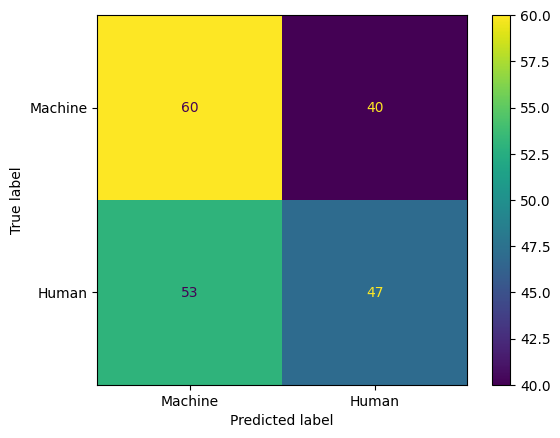

In [102]:
#Functions to process human eval here 
from sklearn import metrics

lab = 25 * ['Human']
actual = 25 * ['Machine']
actual.extend(lab)   #First 25 are fake, last 25 are real 

responses = [] 

required_cols = [106,156]


num_responses = len(head.iloc[:, 106].values)

alphabet_ctr = 0
for i in range(num_responses):
    user_response = head.iloc[i, required_cols[0]:required_cols[1]].values
    responses.extend(user_response)


actual = num_responses * actual

confusion_matrix = metrics.confusion_matrix(actual, responses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Machine', 'Human'])

tn, fp, fn, tp = confusion_matrix.ravel()
print('TN: ', tn , 'FP:', fp, 'FN:', fn, 'TP:', tp)
cm_display.plot()
plt.show()

#plt.savefig('experiment2')


In [5]:
# Go through test pickle file to see fonts we can test with 
# Try to find one instance for each a-z, A-Z, and 0-9

def get_captions_from_test_set():
    test_pickle_path = '../data/fonts/test/filenames.pickle'
    testing_file_names = pickle.load(open(test_pickle_path, 'rb'))

    char_list = []
    char_list.extend(string.ascii_letters)
    char_list.extend(string.digits)

    selected_file_paths = []
    #Retrieve one file name for each character
    for i in testing_file_names:
        char = i.split('\\')[0].split('_')[1]
        if char in char_list:
            char_list.remove(char)
            selected_file_paths.append(i)

    #For each selected path retrieve the corresponding caption 
    text_files_path = '../data/fonts/text'
    testing_captions = [] 

    for i in selected_file_paths:
        selected_file_text_path = os.path.join(text_files_path, i + '.txt')
        with open(selected_file_text_path) as f:
            caption_data = f.read()
            testing_captions.append(caption_data)

    return caption_data 
    

A lowercase y which has traits childlike cartoon and properties regular rounded sans serif dynamic regular mixed caps


In [15]:
root = '../code/samples/e3_model1'
ord = []
for path, subdirs, files in os.walk(root):
    for name in files:
        ord.append(name)

with open(os.path.join(root, 'order.txt'), 'w') as f:
    for i in ord:
        f.write(i)
        f.write('\n')

## Experiment 4: Model Comparison 
### Comparing model A which is trained on data split equally across all fonts (ie. lower_a_roboto can be in train while lower_c_roboto can be in test) with model B which is trained on data split BY FONT (entirety of roboto in train)

In [17]:
# Load model B 
text_encoder = CLIP_TXT_ENCODER(clip_model).to(device)
netG = NetG(64, 100, 512, 256, 3, False, clip_model).to(device)
#path = '../saved_models/pretrained/pre_cc12m.pth'
#path_A = '../saved_models/fonts/GALIP_nf64_normal_fonts_256_2023_04_10_20_51_54/state_epoch_380.pth'
path_B = '../saved_models/fonts/GALIP_nf64_normal_fonts_256_2023_04_27_09_10_54/state_epoch_380.pth'

#checkpoint_A = torch.load(path, map_location=torch.device('cpu'))
checkpoint_B = torch.load(path_B, map_location=torch.device('cpu'))

#netG_A = load_model_weights(netG, checkpoint_A['model']['netG'], multi_gpus=False)
netG_B =load_model_weights(netG, checkpoint_B['model']['netG'], multi_gpus=False)

# Select 10 random instances from Model B's test set and see perforamnce 
# See if it can understand compositionality of prompts

caps = get_captions_from_test_set()

batch_size = 10
noise = torch.randn((batch_size, 100)).to(device)
e4_path = '../samples/e4'

#os.makedirs(e4_path)

# generate from text
with torch.no_grad():
    for i in range(len(caps)):
        caption = caps[i]
        tokenized_text = clip.tokenize([caption]).to(device)
        sent_emb, word_emb = text_encoder(tokenized_text)
        sent_emb = sent_emb.repeat(batch_size,1)
        fake_imgs = netG_B(noise,sent_emb,eval=True).float()
        name = f'{caps[i].replace(" ", "-")}'
        vutils.save_image(fake_imgs.data, e4_path + '/%s.png'%(name), nrow=5, value_range=(-1, 1), normalize=True)

